In [48]:
import numpy as np
import matplotlib.pyplot as plt
import lumicks
import lumicks.pylake as lk
%matplotlib inline
from skimage.transform import rescale

def norm_image(image,inverse=False):
    amin = image.min()
    amax = image.max()
    if inverse:
        return 1- (image-amin)/(amax-amin)    
    else:
        return (image-amin)/(amax-amin)

In [49]:
irm = lk.ImageStack("data/20231228-A_IRM_0.5_beads.tiff")  # Loading a stack.
wt = lk.ImageStack("data/20231228-A_WT_0.5_beads.tiff")  # Loading a stack.


In [50]:
wt_g = norm_image(wt.get_image(channel='green')).astype('float32')
wt_r = norm_image(wt.get_image(channel='red')).astype('float32')
wt_b = norm_image(wt.get_image(channel='blue')).astype('float32')
#plt.imshow(wt_g)

In [51]:
irm_g = norm_image(irm.get_image(), inverse=True).astype('float32')
#plt.imshow(irm_g)


(597, 654)
(516, 690)
[544 728]


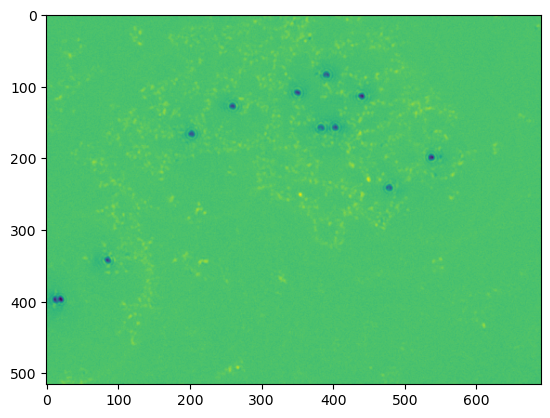

In [52]:

irm_g = rescale(irm_g, wt._pixel_calibration_factors/irm._pixel_calibration_factors, anti_aliasing=True)
plt.imshow(irm_g)

#Should I rescale by pixel calibration? --> then there are less parameters...
print(wt_g.shape)
print(irm_g.shape)
print(np.delete(irm.shape, 0))

In [53]:
def get_padding_shape(desired, current):
    """Get the padding on the left and right"""
    diff_0 = desired[0] - current[0]
    diff_1 = desired[1] - current[1]
    half_0 = diff_0//2
    half_1 = diff_1//2
    return((half_0, diff_0-half_0),(half_1, diff_1-half_1))

get_padding_shape((6,6),(3,3))

((1, 2), (1, 2))

In [90]:
padding_dim = np.max((wt_g.shape, irm_g.shape), axis=0)

#wt_g=np.pad(wt_g, get_padding_shape(padding_dim, wt_g.shape), mode='edge')
#irm_g=np.pad(irm_g,get_padding_shape(padding_dim, irm_g.shape), mode='edge')
#assert(wt_g.shape==irm_g.shape)
#plt.imshow(irm_g)

In [55]:
wt_g.dtype

dtype('float32')

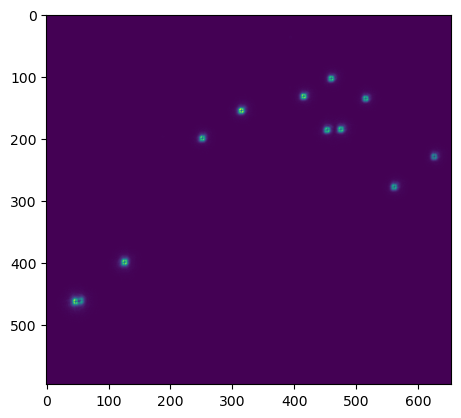

In [56]:

import cv2
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=3)
    
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

plt.imshow(get_gradient(wt_g))


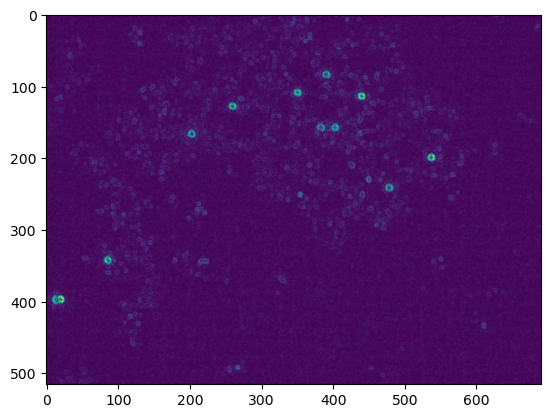

In [57]:
plt.imshow(get_gradient(irm_g))

In [127]:
# Define motion model
warp_mode = cv2.MOTION_AFFINE
 
# Set the warp matrix to identity.
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)
 
# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 500,  1e-5)
 
# Warp the blue and green channels to the red channel
(cc, warp_matrix) = cv2.findTransformECC(get_gradient(wt_g), get_gradient(irm_g), warp_matrix, warp_mode, criteria)
#(cc, warp_matrix) = cv2.findTransformECC(irm_g, wt_r, warp_matrix, warp_mode, criteria)


print(warp_matrix)
print(cc)



[[ 9.8809397e-01 -4.3899543e-04  5.7539525e+00]
 [ 1.5226495e-03  1.0017251e+00 -2.3933887e+00]]
0.02872643188505035


In [63]:
if warp_mode == cv2.MOTION_HOMOGRAPHY :
# Use Perspective warp when the transformation is a Homography
    irm_g_al = cv2.warpPerspective (irm_g, warp_matrix, irm_g.shape, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
# Use Affine warp when the transformation is not a Homography
    irm_g_al = cv2.warpAffine(irm_g, warp_matrix, irm_g.shape, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)


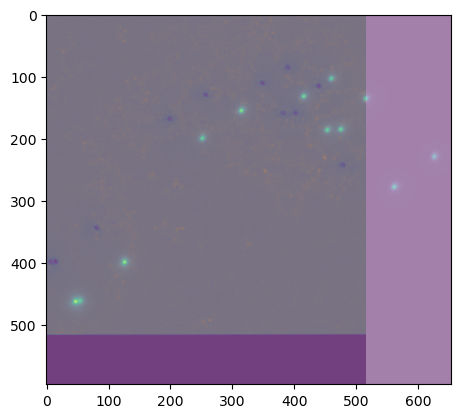

In [69]:
plt.imshow(irm_g_al, alpha=0.5)
plt.imshow(wt_g, alpha=0.5)

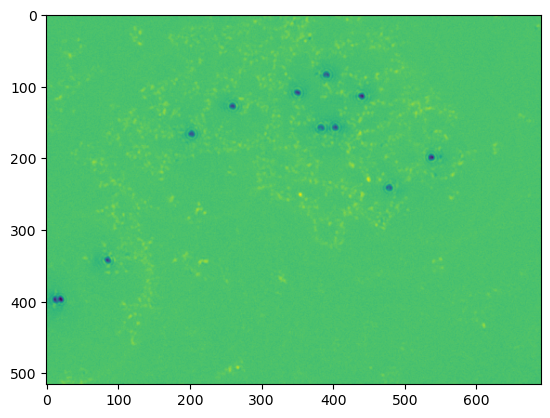

In [65]:
plt.imshow(irm_g)

In [81]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

0.003283138974627133


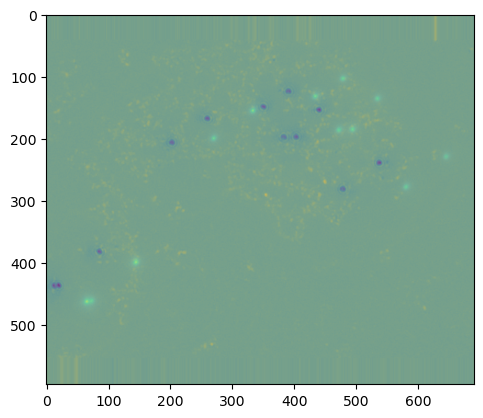

In [103]:

padding_dim = np.max((wt_g.shape, irm_g.shape), axis=0)

wt_g_pad=np.pad(wt_g, get_padding_shape(padding_dim, wt_g.shape), mode='edge').astype('float32')
irm_g_pad=np.pad(irm_g,get_padding_shape(padding_dim, irm_g.shape), mode='edge').astype('float32')

plt.imshow(wt_g_pad, alpha=0.5)
plt.imshow(irm_g_pad, alpha=0.5)
ecc = cv2.computeECC(wt_g_pad, irm_g_pad)
print(ecc)

In [126]:
def align(shift_x, shift_y, scale, rotation, centre_x, centre_y):
    M = np.float32([[0,0,shift_x],
                    [0,0,shift_y]])
    rows,cols = irm_g.shape
    R = cv2.getRotationMatrix2D(( centre_x, centre_y),rotation, scale)
    
    padding_dim = np.max((wt_g.shape, irm_g.shape), axis=0)
    

    irm_g_test = cv2.warpAffine(irm_g.astype('float32'), M+R, padding_dim, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    #print(wt_g_pad.shape, irm_g_pad.shape)
    
    padding_dim = np.max((wt_g.shape, irm_g_test.shape), axis=0)
    wt_g_pad=get_gradient(np.pad(wt_g.astype('float32'), get_padding_shape(padding_dim, wt_g.shape), mode='edge'))
    irm_g_pad=get_gradient(np.pad(irm_g_test.astype('float32'),get_padding_shape(padding_dim, irm_g_test.shape), mode='edge'))
    
    ecc = cv2.computeECC(wt_g_pad, irm_g_pad)

    plt.imshow(wt_g_pad, alpha=0.5)
    plt.imshow(irm_g_pad, alpha=0.5)
    
    return (ecc, plt.gcf())

interact(align, 
         shift_x=widgets.FloatSlider(value=-6.2, min=-100, max=100, step=0.1), 
         shift_y=widgets.FloatSlider(value=-49.20, min=-100, max=100, step=0.1), 
         scale=widgets.FloatSlider(value=0.89, min=0.8, max=1.2, step=0.01), 
         rotation=widgets.FloatSlider(value=-0.6, min=-180, max=180, step=0.1), 
         centre_x=widgets.FloatSlider(value=0, min=-100, max=100, step=0.1), 
         centre_y=widgets.FloatSlider(value=0, min=-100, max=100, step=0.1))

interactive(children=(FloatSlider(value=-6.2, description='shift_x', min=-100.0), FloatSlider(value=-49.2, des…

<function __main__.align(shift_x, shift_y, scale, rotation, centre_x, centre_y)>

In [1]:
M

NameError: name 'M' is not defined